# Estimating Urban Service Levels

First we load city boundaries, and partition the city in a grid

In [1]:
import sys
sys.path.append('..')
import urbanpy as up
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import os

In [2]:
lima_boundaries = up.download.nominatim_osm('lima, peru')

In [3]:
lima_hexs = up.geom.gen_hexagons(9, lima_boundaries)

In [4]:
lima_hexs.shape

(172, 2)

## How are we going to estimate urban service level?

For each hexagon (centroid) we are going to generate isochrones for 30 minutes walk, with 5 minutes bands. For each band we are going to count the number of PoIs by categories.

### Isochrones Demo

#### Load Graphs

In [5]:
lima_metro_boundaries = up.geom.merge_geom_downloads(
    [up.download.nominatim_osm('Lima, Peru', 2),
     up.download.nominatim_osm('Callao, Peru', 1)]
)

In [6]:
(lima_metro_boundaries.explode().area / lima_metro_boundaries.area[0]).round(4).idxmax()

# The polygon with greatest area is >99% of the total multipolygon area

(0, 10)

In [7]:
lima_graph = up.download.osmnx_graph('polygon', 'walk', geom=lima_metro_boundaries.explode().geometry[0][10])

In [8]:
lima_downtown_graph = up.download.osmnx_graph('place', 'walk', 'Lima, Peru')

In [9]:
lima_graph_proj = ox.project_graph(lima_graph)

In [10]:
lima_downtown_graph_proj = ox.project_graph(lima_downtown_graph)

In [11]:
[lima_downtown_graph_proj.nodes[4578479048]['y'],
lima_downtown_graph_proj.nodes[4578479048]['x']]

[-1333048.5299343618, 274631.8161092551]

In [12]:
[lima_downtown_graph_proj.nodes[4578479061]['y'],
lima_downtown_graph_proj.nodes[4578479061]['x']]

[-1333026.0715693592, 274795.5781210733]

#### Generate isochrones (with graph size - time benchmarking)

In [13]:
TIME_BENCHMARK = False

In [14]:
%%timeit
if TIME_BENCHMARK:
    up.routing.isochrone_from_graph(lima_graph, [[lima_graph.nodes[4578479048]['x'], lima_graph.nodes[4578479048]['y']]], [5, 10], 'walking')

15.3 ns ± 0.171 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [15]:
%%timeit
if TIME_BENCHMARK:
    up.routing.isochrone_from_graph(lima_downtown_graph, [[lima_graph.nodes[4578479048]['x'], lima_graph.nodes[4578479048]['y']]], [5, 10], 'walking')

15.3 ns ± 0.222 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [16]:
isochrones = up.routing.isochrone_from_graph(
    graph=lima_graph, 
    locations=[[lima_graph.nodes[4578479048]['x'], 
                lima_graph.nodes[4578479048]['y']]],
    time_range=[5, 10],
    profile='walking'
)

#### Visualize isochrone

<AxesSubplot:>

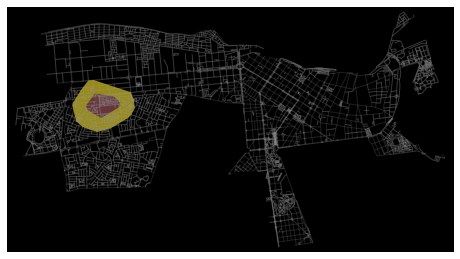

In [17]:
fig, ax = ox.plot_graph(lima_downtown_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k')

isochrones.plot('contour', ax=ax, alpha=0.6, zorder=-1)

### Scale isochrone calculation up to every hexagon centroid in Lima's Downtown

In [18]:
lima_hexs['lon'] = lima_hexs.geometry.centroid.x
lima_hexs['lat'] = lima_hexs.geometry.centroid.y

hexs_centroids = lima_hexs[['lon','lat']].values.tolist()

/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [19]:
OUTPUT_FILE_PATH = 'output/lima_downtown_isochrones.geojson'

In [20]:
if os.path.isfile(OUTPUT_FILE_PATH):
    downtown_isochrones = gpd.read_file(OUTPUT_FILE_PATH)
else:
    downtown_isochrones = up.routing.isochrone_from_graph(
        graph=lima_graph, 
        locations=hexs_centroids,
        time_range=[5, 10, 15, 20, 25, 30], 
        profile='walking'
    )

In [21]:
downtown_isochrones.head()

,group_index,contour,geometry
0,0,30,"POLYGON ((-77.05900 -12.06122, -77.05909 -12.0..."
1,0,25,"POLYGON ((-77.05423 -12.05668, -77.05773 -12.0..."
2,0,20,"POLYGON ((-77.05651 -12.05387, -77.06476 -12.0..."
3,0,15,"POLYGON ((-77.05466 -12.05096, -77.05500 -12.0..."
4,0,10,"POLYGON ((-77.05399 -12.04765, -77.05741 -12.0..."


In [22]:
downtown_isochrones.shape

(1032, 3)

In [23]:
# Validate every geom is of the correct type
(downtown_isochrones.geom_type != 'Polygon').sum()

0

In [24]:
# Save output
downtown_isochrones.to_file('output/lima_downtown_isochrones.geojson', driver='GeoJSON')

#### Visualize an isochromes sample in a map

In [25]:
SAMPLE_SIZE = 5

In [26]:
# Create sample & filter time ranges for a better visualization
n_isochrones = downtown_isochrones.shape[0]
random_indices = np.random.choice(downtown_isochrones['group_index'].unique(), size=SAMPLE_SIZE, replace=False)

sample_filter = downtown_isochrones['group_index'].isin(random_indices)
timer_filter = downtown_isochrones['contour'].isin([5, 10, 15])

ischrones_rsample = downtown_isochrones[sample_filter & timer_filter]

In [27]:
import matplotlib.pyplot as plt

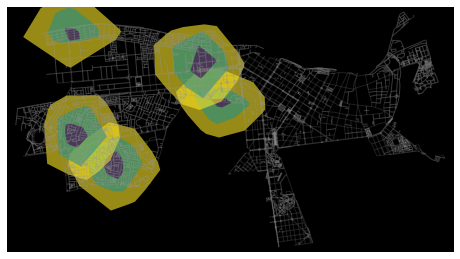

In [29]:
fig, ax = ox.plot_graph(lima_downtown_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k')

ischrones_rsample.plot('contour', ax=ax, alpha=0.6, zorder=-1)

plt.savefig('isochrones_example.png', dpi=300, bbox_inches='tight')

### Which PoIs categories we are going to use for estimating service levels?

- Food & Beverage (Restaurants & similar )
- Cultural places
- Night Places
- Pharmacies & Sanitization
- Sports Equiptment 
- Clothes & Shoes
- Furniture
- Beauty
- Nanostores
- Traditional Markets

# [OpenStreetMaps Map Features](https://wiki.openstreetmap.org/wiki/Map_Features)

1. Primary features
    1. [Amenity](#Amenity*)
        1. Sustenance
        1. Education
        1. Transportation
        1. Financial
        1. Healthcare
        1. Entertainment, Arts & Culture
        1. Others
    1. Building
        1. Accommodation
        1. Commercial
        1. Religious
        1. Civic/Amenity
        1. Agricultural/Plant production
        1. Sports
        1. Storage
        1. Cars
        1. Power/Technical buildings
        1. Other Buildings
        1. Additional Attributes
    1. Highway
        1. Roads
        1. Link roads
        1. Special road types
        1. Paths
        1. Lifecycle
        1. Attributes
        1. Other highway features
    1. Historic
    1. Leisure
    1. Office
    1. Public Transport
    1. Shop
        1. Food, beverages
        1. General store, department store, mall
        1. Clothing, shoes, accessories
        1. Discount store, charity
        1. Health and beauty
        1. Do-it-yourself, household, building materials, gardening
        1. Furniture and interior
        1. Electronics
        1. Outdoors and sport, vehicles
        1. Art, music, hobbies
        1. Stationery, gifts, books, newspapers
        1. Others
    1. Sport
    1. Tourism

## Amenity*

### Sustenance
amenity: [bar, bbq, biergarten, cafe, drinking_water, fast_food, 
          food_court, ice_cream, pub, restaurant]

### Education
amenity: [college, kindergarten, language_school, library, toy_library,
          music_school, school, university]

### Transportation
amenity: [bicycle_parking, bicycle_repair_station, bicycle_rental, 
          boat_rental, boat_sharing, bus_station, car_rental, 
          car_sharing, car_wash, vehicle_inspection, charging_station,
          ferry_terminal, fuel, grit_bin, motorcycle_parking, parking,
          parking_entrance, parking_space, taxi]

### Financial
amenity: [atm, bank, bureau_de_change]

### Healthcare
amenity: [baby_hatch, clinic, dentist, doctors, hospital,
           nursing_home, pharmacy, social_facility, veterinary]

### Entertainment, Arts & Culture
amenity: [arts_centre, brothel, casino, cinema, community_centre,
          fountain, gambling, nightclub, planetarium, public_bookcase,
          social_centre, stripclub, studio, swingerclub, theatre]

### Others
amenity: [animal_boarding, animal_shelter, baking_oven, bench,
          childcare, clock, conference_centre, courthouse, crematorium,
          dive_centre, embassy, fire_station, firepit, funeral_hall, 
          give_box, grave_yard, gym, hunting_stand, internet_cafe, 
          kitchen, kneipp_water_cure, monastery, photo_booth, 
          place_of_worship, polic, post_box, post_depot, post_office,
          prison, public_bath, public_building, ranger_station, 
          recycling, refugee_site, sanitary_dump_station, sauna, 
          shelter, shower, telephone, toilets, townhall, 
          vending_machine, waste_basket, waste_disposal, 
          waste_transfer_station, watering_place, water_point]
          
> The amenities in the lists are only type **node**

> **Excluded from Others** (Not node): marketplace, way - area, A marketplace where goods and services are traded daily or weekly.

In [28]:
buildings = dict(acommodation = ["apartments"
, "bungalow"
, "cabin"
, "detached"
, "dormitory"
, "farm"
, "ger"
, "hotel"
, "house"
, "houseboat"
, "residential"
, "semidetached_house"
, "static_caravan"
, "terrace"],

commercial = ["commercial"
,"industrial" 
,"kiosk" 
,"office" 
,"retail" 
,"supermarket" 
,"warehouse" ],

religious = ["cathedral" 
,"chapel" 
,"church" 
,"mosque" 
,"religious" 
,"shrine" 
,"synagogue" 
,"temple" ],

civic = ["bakehouse" 
,"civic" 
,"fire_station" 
,"government" 
,"hospital" 
,"kindergarten" 
,"public" 
,"school" 
,"toilets" 
,"train_station" 
,"transportation" 
,"university" ],

agricultural = ["barn" 
,"conservatory" 
,"cowshed" 
,"farm_auxiliary" 
,"greenhouse" 
,"slurry_tank" 
,"stable" 
,"sty" ],

sports = ["grandstand" 
,"pavilion" 
,"riding_hall" 
,"sports_hall" 
,"stadium" ],

storage = ["hangar" 
,"hut" 
,"shed" ],

cars = ["carport" 
,"garage" 
,"garages" 
,"parking" ],

technical = ["digester" 
,"service" 
,"transformer_tower" 
,"water_tower" ],

others = ["bunker" 
,"bridge" 
,"construction" 
,"gatehouse" 
,"roof" 
,"ruins" 
,"tree_house" 
,"yes" 
,"user defined"],)

In [29]:
shops = dict(foood_and_beverages = ["alcohol","bakery","beverages",
                       "brewing_supplies","butcher","cheese",
                       "chocolate","coffee","confectionery",
                       "convenience","deli","dairy","farm",
                       "frozen_food","greengrocer","health_food",
                       "ice_cream","organic","pasta","pastry",
                       "seafood","spices","tea","wine","water"],

mall = ["department_store", "general", "kiosk", "mall",
        "supermarket", "wholesale"],

clothing = ["baby_goods", "bag", "boutique", "clothes", "fabric", 
            "fashion", "fashion_accessories", "jewelry", "leather", 
            "sewing", "shoes", "tailor", "watches", "wool",],

discount_store = ["charity", "second_hand", "variety_store"],

health_and_beauty = ["beauty", "chemist", "cosmetics", "drugstore",
                     "erotic", "hairdresser", "hairdresser_supply", 
                     "hearing_aids", "herbalist", "massage", 
                     "medical_supply", "nutrition_supplements", 
                     "optician", "perfumery", "tattoo"],

diy = ["agrarian", "appliance", "bathroom_furnishing", "doityourself",
       "electrical", "energy", "fireplace", "florist", "garden_centre",
       "garden_furniture", "gas", "glaziery", "hardware", "houseware",
       "locksmith", "paint", "security", "trade", "windows"],

furniture_and_interior = ["antiques", "bed", "candles", "carpet",
                          "curtain", "doors", "flooring", "furniture",
                          "household_linen", "interior_decoration", 
                          "kitchen", "lamps", "lighting", "tiles",
                          "window_blind"],

electronics = ["computer", "electronics", "hifi", "mobile_phone",
               "radiotechnics", "vacuum_cleaner"],

outdoors = ["atv", "bicycle", "boat", "car", "car_repair", "car_parts",
            "caravan", "fuel", "fishing", "golf", "hunting", "jetski",
            "military_surplus", "motorcycle", "outdoor", "scuba_diving",
            "ski", "snowmobile", "sports", "swimming_pool", "trailer", 
            "tyres"],

art = ["art", "collector", "craft", "frame", "games", "model",
       "music", "musical_instrument", "photo", "camera", "trophy",
       "video", "video_games"],

books = ["anime", "books", "gift", "lottery", "newsagent",
         "stationery", "ticket"],

others = ["bookmaker", "cannabis", "copyshop", "dry_cleaning",
          "e-cigarette", "funeral_directors", "laundry", 
          "money_lender", "party", "pawnbroker", "pet", 
          "pet_grooming", "pest_control", "pyrotechnics",
          "religion", "storage_rental", "tobacco", "toys", 
          "travel_agency", "vacant", "weapons", "outpost"],)

In [30]:
## Amenity*

### Sustenance
amenities = dict(sustenance = ["bar", "bbq", "biergarten", "cafe", "drinking_water", "fast_food", 
          "food_court", "ice_cream", "pub", "restaurant"],

### Education
education = ["college", "kindergarten", "language_school", "library", "toy_library",
          "music_school", "school", "university"],

### Transportation
transportation = ["bicycle_parking", "bicycle_repair_station", "bicycle_rental",
          "boat_rental", "boat_sharing", "bus_station", "car_rental",
          "car_sharing", "car_wash", "vehicle_inspection", "charging_station",
          "ferry_terminal", "fuel", "grit_bin", "motorcycle_parking", "parking",
          "parking_entrance", "parking_space", "taxi"],

### Financial
financial = ["atm", "bank", "bureau_de_change"],

### Healthcare
healthcare = ["baby_hatch", "clinic", "dentist", "doctors", "hospital",
           "nursing_home", "pharmacy", "social_facility", "veterinary"],

### Entertainment", "Arts & Culture
entertainment = ["arts_centre", "brothel", "casino", "cinema", "community_centre",
          "fountain", "gambling", "nightclub", "planetarium", "public_bookcase",
          "social_centre", "stripclub", "studio", "swingerclub", "theatre"],

### Others
others = ["animal_boarding", "animal_shelter", "baking_oven", "bench",
          "childcare", "clock", "conference_centre", "courthouse", "crematorium",
          "dive_centre", "embassy", "fire_station", "firepit", "funeral_hall",
          "give_box", "grave_yard", "gym", "hunting_stand", "internet_cafe",
          "kitchen", "kneipp_water_cure", "monastery", "photo_booth",
          "place_of_worship", "polic", "post_box", "post_depot", "post_office",
          "prison", "public_bath", "public_building", "ranger_station",
          "recycling", "refugee_site", "sanitary_dump_station", "sauna",
          "shelter", "shower", "telephone", "toilets", "townhall",
          "vending_machine", "waste_basket", "waste_disposal",
          "waste_transfer_station", "watering_place", "water_point"])

In [31]:
def gen_mapper(values):
    mapper = dict()

    for key, value in values.items():
        for el in value:
            mapper[el] = key
            
    return mapper

In [43]:
shop_mapper = gen_mapper(shops)
amenities_mapper = gen_mapper(amenities)

In [33]:
query = """
[timeout:120][out:json][bbox];
(
  node[shop];
);
out body geom;
"""
response = up.download.overpass_pois(lima_boundaries.total_bounds, custom_query=query)

In [36]:
data = response.json() # get json data
overpass_df = pd.DataFrame.from_dict(data['elements']) # transform data to dataframe

In [37]:
overpass_df_with_tags = overpass_df[~overpass_df['tags'].isna()]

In [38]:
overpass_df.shape, overpass_df_with_tags.shape

((1373, 5), (1373, 5))

In [39]:
tags_records = overpass_df_with_tags['tags'].values.tolist()

In [40]:
tags_df = pd.DataFrame.from_records(tags_records)

In [41]:
tags_df['shop'].value_counts()

yes                   230
convenience           116
clothes               103
mall                   55
hardware               54
                     ... 
dairy                   1
photo_studio            1
no                      1
building_materials      1
trophy                  1
Name: shop, Length: 96, dtype: int64

In [44]:
categories = tags_df['amenity'].map(amenities_mapper)

<AxesSubplot:>

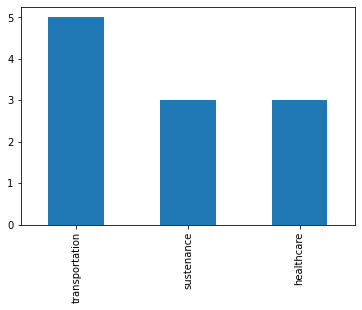

In [45]:
categories.value_counts().plot(kind='bar')

In [46]:
services = tags_df['shop'].map(shop_mapper)

In [47]:
services.isna().sum(), services.shape

(242, (1373,))

<AxesSubplot:>

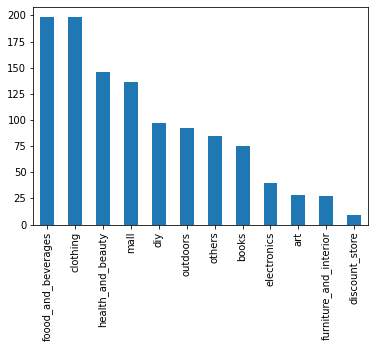

In [48]:
services.value_counts().plot(kind='bar')

In [49]:
tags_df['shop_category'] = services

In [50]:
overpass_geo = gpd.points_from_xy(overpass_df_with_tags.lon, overpass_df_with_tags.lat)

In [51]:
overpass_gdf = gpd.GeoDataFrame(
    pd.concat([overpass_df_with_tags, tags_df], axis=1),
    geometry=overpass_geo,
    crs='EPSG:4326'
)

<AxesSubplot:>

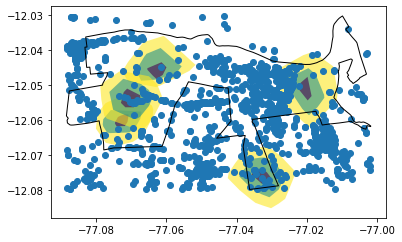

In [55]:
ax = overpass_gdf.plot()
lima_boundaries.plot(ax=ax, facecolor='none', edgecolor='k')
ischrones_rsample.plot('contour', ax=ax, alpha=0.6, zorder=-1)

In [ ]:
from collections import defaultdict 

In [81]:
def count_pois(row):
    intersects = overpass_gdf.intersects(row.geometry)
    
    if intersects.sum() > 0:
        pois_count = (overpass_gdf[intersects]
        .groupby('shop_category').count()['geometry'])
        
        return pois_count
    
    return np.nan

pois_count = downtown_isochrones.apply(count_pois, axis=1)

In [82]:
pois_count

,art,books,clothing,discount_store,diy,electronics,foood_and_beverages,furniture_and_interior,health_and_beauty,mall,others,outdoors
0,13.0,9.0,8.0,NaN,28.0,7.0,23.0,1.0,38.0,6.0,10.0,27.0
1,10.0,4.0,8.0,NaN,19.0,6.0,7.0,NaN,15.0,5.0,6.0,21.0
2,1.0,NaN,6.0,NaN,13.0,5.0,2.0,NaN,5.0,2.0,1.0,4.0
3,NaN,NaN,2.0,NaN,3.0,NaN,1.0,NaN,NaN,1.0,NaN,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,2.0,9.0,4.0,2.0,8.0,3.0,27.0,5.0,13.0,12.0,15.0,9.0
1028,2.0,7.0,2.0,1.0,5.0,NaN,16.0,4.0,10.0,6.0,9.0,2.0
1029,1.0,6.0,2.0,NaN,3.0,NaN,16.0,4.0,9.0,2.0,7.0,2.0
1030,1.0,5.0,NaN,NaN,1.0,NaN,9.0,NaN,3.0,1.0,1.0,1.0


In [80]:
downtown_isochrones.shape

(1032, 3)

In [87]:
downtown_iso = pd.concat([downtown_isochrones, pois_count], axis=1)

In [88]:
downtown_iso.to_file('output/lima_downtown_isochrones_poi_count.geojson', driver='GeoJSON')

In [90]:
downtown_iso['contour'].unique()

array([30, 25, 20, 15, 10,  5])